# Data Mining Project
### Giorgio Donati, g.donati24@studenti.unipi.it
### Pietro Francaviglia, p.francaviglia1@studenti.unipi.it
#### A.Y. 2021-2022


## Libraries and datasets

In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# load datasets
basket_df = pd.read_csv('datasets/baskets_supermarket.csv')
categories_df = pd.read_csv('datasets/item_categories.csv')
items_df = pd.read_csv('datasets/items.csv')

In [65]:
# global variables for column names
# existing
ITEM = 'item_id'
CAT = 'item_category_id'
DATE = 'date'
SHOP = 'shop_id'
UPRICE = 'item_price'
QTY = 'item_cnt_day'
USER = 'user_id'
BASKET = 'basket_id'

# new
TMP = 'temp_id'
TPRICE = 'total_price'
BDQTY = 'item_dist_count'
BQTY = 'item_count'

## Basket dataset

In [3]:
basket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504087 entries, 0 to 504086
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    504087 non-null  int64  
 1   date          352861 non-null  object 
 2   shop_id       469023 non-null  float64
 3   item_id       405085 non-null  float64
 4   item_price    451795 non-null  float64
 5   item_cnt_day  497039 non-null  float64
 6   user_id       433351 non-null  float64
 7   basket_id     437967 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 30.8+ MB


### Cleaning ID columns

In [64]:
non_floating_attributes = [SHOP, ITEM, QTY, USER]
for col in non_floating_attributes:
    basket_df[col] = basket_df[col].astype('Int64')

basket_df[DATE] = pd.to_datetime(basket_df[DATE])
    
basket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504087 entries, 0 to 504086
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    504087 non-null  int64         
 1   date          352861 non-null  datetime64[ns]
 2   shop_id       469023 non-null  Int64         
 3   item_id       405085 non-null  Int64         
 4   item_price    451795 non-null  float64       
 5   item_cnt_day  497039 non-null  Int64         
 6   user_id       433351 non-null  Int64         
 7   basket_id     437967 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 32.7+ MB


#### Subset with basket_id

In [5]:
stored_basket_df = basket_df[basket_df[BASKET].notna()]
stored_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437967 entries, 0 to 504086
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    437967 non-null  int64         
 1   date          306631 non-null  datetime64[ns]
 2   shop_id       407650 non-null  Int64         
 3   item_id       352049 non-null  Int64         
 4   item_price    392583 non-null  float64       
 5   item_cnt_day  431863 non-null  Int64         
 6   user_id       376422 non-null  Int64         
 7   basket_id     437967 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 31.7+ MB


In [6]:
def integrate(int_attr, gr_attr, df):
    df[int_attr] = df.groupby(gr_attr)[int_attr].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) == 1 else x))

In [7]:
basket_dependent_attributes = [DATE, SHOP, USER]
for attr in basket_dependent_attributes:
    integrate(attr, BASKET, stored_basket_df)

stored_basket_df = stored_basket_df.dropna(subset=basket_dependent_attributes, thresh=2)
    
stored_basket_df.info()

/tmp/ipykernel_40358/631791158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[int_attr] = df.groupby(gr_attr)[int_attr].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) == 1 else x))
/tmp/ipykernel_40358/631791158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[int_attr] = df.groupby(gr_attr)[int_attr].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) == 1 else x))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 437708 entries, 0 to 504086
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    437708 non-null  int64         
 1   date          435787 non-null  datetime64[ns]
 2   shop_id       437524 non-null  Int64         
 3   item_id       351844 non-null  Int64         
 4   item_price    392353 non-null  float64       
 5   item_cnt_day  431606 non-null  Int64         
 6   user_id       437212 non-null  Int64         
 7   basket_id     437708 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 31.7+ MB


/tmp/ipykernel_40358/631791158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[int_attr] = df.groupby(gr_attr)[int_attr].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) == 1 else x))


#### Subset without basket_id

In [8]:
null_basket_df = basket_df[basket_df[BASKET].isna()]

null_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66120 entries, 20 to 504077
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    66120 non-null  int64         
 1   date          46230 non-null  datetime64[ns]
 2   shop_id       61373 non-null  Int64         
 3   item_id       53036 non-null  Int64         
 4   item_price    59212 non-null  float64       
 5   item_cnt_day  65176 non-null  Int64         
 6   user_id       56929 non-null  Int64         
 7   basket_id     0 non-null      object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.8+ MB


In [9]:
null_basket_df = null_basket_df.dropna(subset=basket_dependent_attributes)
null_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36987 entries, 61 to 504077
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    36987 non-null  int64         
 1   date          36987 non-null  datetime64[ns]
 2   shop_id       36987 non-null  Int64         
 3   item_id       29726 non-null  Int64         
 4   item_price    33150 non-null  float64       
 5   item_cnt_day  36454 non-null  Int64         
 6   user_id       36987 non-null  Int64         
 7   basket_id     0 non-null      object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.7+ MB


In [10]:
null_basket_df[TMP] = null_basket_df.groupby(basket_dependent_attributes).ngroup().astype(int)

In [11]:
new_basket_df = null_basket_df[null_basket_df.duplicated(subset=[TMP], keep=False)]
new_basket_df[BASKET] = 'R' + null_basket_df[TMP].astype(str)
new_basket_df = new_basket_df.drop(TMP, 1)
new_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27748 entries, 61 to 504051
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    27748 non-null  int64         
 1   date          27748 non-null  datetime64[ns]
 2   shop_id       27748 non-null  Int64         
 3   item_id       22323 non-null  Int64         
 4   item_price    24897 non-null  float64       
 5   item_cnt_day  27342 non-null  Int64         
 6   user_id       27748 non-null  Int64         
 7   basket_id     27748 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.0+ MB


/tmp/ipykernel_40358/2700372355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_basket_df['basket_id'] = 'R' + null_basket_df['new_id'].astype(str)
/tmp/ipykernel_40358/2700372355.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  new_basket_df = new_basket_df.drop('new_id', 1)


In [12]:
single_basket_df = null_basket_df.drop_duplicates(subset=[TMP], keep=False)
single_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9239 entries, 121 to 504077
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    9239 non-null   int64         
 1   date          9239 non-null   datetime64[ns]
 2   shop_id       9239 non-null   Int64         
 3   item_id       7403 non-null   Int64         
 4   item_price    8253 non-null   float64       
 5   item_cnt_day  9112 non-null   Int64         
 6   user_id       9239 non-null   Int64         
 7   basket_id     0 non-null      object        
 8   new_id        9239 non-null   int64         
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 757.9+ KB


In [13]:
restoring_basket_df = pd.concat([stored_basket_df, single_basket_df])
restoring_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446947 entries, 0 to 504077
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    446947 non-null  int64         
 1   date          445026 non-null  datetime64[ns]
 2   shop_id       446763 non-null  Int64         
 3   item_id       359247 non-null  Int64         
 4   item_price    400606 non-null  float64       
 5   item_cnt_day  440718 non-null  Int64         
 6   user_id       446451 non-null  Int64         
 7   basket_id     437708 non-null  object        
 8   new_id        9239 non-null    float64       
dtypes: Int64(4), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 35.8+ MB


In [14]:
integrate(BASKET, basket_dependent_attributes, restoring_basket_df)
restoring_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446947 entries, 0 to 504077
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    446947 non-null  int64         
 1   date          445026 non-null  datetime64[ns]
 2   shop_id       446763 non-null  Int64         
 3   item_id       359247 non-null  Int64         
 4   item_price    400606 non-null  float64       
 5   item_cnt_day  440718 non-null  Int64         
 6   user_id       446451 non-null  Int64         
 7   basket_id     443752 non-null  object        
 8   new_id        9239 non-null    float64       
dtypes: Int64(4), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 35.8+ MB


In [15]:
restoring_basket_df = restoring_basket_df.dropna(subset=[BASKET, DATE, SHOP, USER], thresh=3)
restoring_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444346 entries, 0 to 504077
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    444346 non-null  int64         
 1   date          444346 non-null  datetime64[ns]
 2   shop_id       444346 non-null  Int64         
 3   item_id       357166 non-null  Int64         
 4   item_price    398288 non-null  float64       
 5   item_cnt_day  438157 non-null  Int64         
 6   user_id       444346 non-null  Int64         
 7   basket_id     443752 non-null  object        
 8   new_id        9239 non-null    float64       
dtypes: Int64(4), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 35.6+ MB


In [16]:
restoring_basket_df[BASKET] = restoring_basket_df[BASKET].fillna('S' + restoring_basket_df[TMP].astype(str))
restoring_basket_df = restoring_basket_df.drop(TMP, 1)
restoring_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444346 entries, 0 to 504077
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    444346 non-null  int64         
 1   date          444346 non-null  datetime64[ns]
 2   shop_id       444346 non-null  Int64         
 3   item_id       357166 non-null  Int64         
 4   item_price    398288 non-null  float64       
 5   item_cnt_day  438157 non-null  Int64         
 6   user_id       444346 non-null  Int64         
 7   basket_id     444346 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 32.2+ MB


/tmp/ipykernel_40358/2726479186.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  restoring_basket_df = restoring_basket_df.drop('new_id', 1)


#### Merging subsets

In [17]:
clean_basket_df = pd.concat([restoring_basket_df, new_basket_df])
clean_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472094 entries, 0 to 504051
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    472094 non-null  int64         
 1   date          472094 non-null  datetime64[ns]
 2   shop_id       472094 non-null  Int64         
 3   item_id       379489 non-null  Int64         
 4   item_price    423185 non-null  float64       
 5   item_cnt_day  465499 non-null  Int64         
 6   user_id       472094 non-null  Int64         
 7   basket_id     472094 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 34.2+ MB


### Cleaning item columns

In [18]:
clean_basket_df = clean_basket_df.dropna(subset=QTY)
clean_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465499 entries, 0 to 504051
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    465499 non-null  int64         
 1   date          465499 non-null  datetime64[ns]
 2   shop_id       465499 non-null  Int64         
 3   item_id       374207 non-null  Int64         
 4   item_price    417261 non-null  float64       
 5   item_cnt_day  465499 non-null  Int64         
 6   user_id       465499 non-null  Int64         
 7   basket_id     465499 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 33.7+ MB


In [19]:
clean_basket_df = clean_basket_df.dropna(subset=[ITEM, UPRICE], thresh=1)
clean_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456017 entries, 0 to 504051
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    456017 non-null  int64         
 1   date          456017 non-null  datetime64[ns]
 2   shop_id       456017 non-null  Int64         
 3   item_id       374207 non-null  Int64         
 4   item_price    417261 non-null  float64       
 5   item_cnt_day  456017 non-null  Int64         
 6   user_id       456017 non-null  Int64         
 7   basket_id     456017 non-null  object        
dtypes: Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 33.1+ MB


In [66]:
clean_basket_df[ITEM] = clean_basket_df[ITEM].fillna(-1)
clean_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455705 entries, 0 to 455704
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   item_id       455705 non-null  Int64         
 1   date          455705 non-null  datetime64[ns]
 2   shop_id       455705 non-null  Int64         
 3   item_price    455705 non-null  float64       
 4   item_cnt_day  455705 non-null  Int64         
 5   user_id       455705 non-null  Int64         
 6   basket_id     455705 non-null  object        
 7   total_price   455705 non-null  Float64       
dtypes: Float64(1), Int64(4), datetime64[ns](1), float64(1), object(1)
memory usage: 30.0+ MB


In [21]:
temp = clean_basket_df.groupby(ITEM)[UPRICE].mean()
priced_items_df = pd.merge(items_df, temp, on=ITEM, how='outer')
priced_items_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22171 entries, 0 to 22170
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   item_name         22170 non-null  object 
 1   item_id           22171 non-null  Int64  
 2   item_category_id  22170 non-null  float64
 3   item_price        16824 non-null  float64
dtypes: Int64(1), float64(2), object(1)
memory usage: 887.7+ KB


In [56]:
clean_basket_df = clean_basket_df.set_index(ITEM).join(priced_items_df.set_index(ITEM), lsuffix='', rsuffix='_temp').reset_index()
clean_basket_df[UPRICE] = clean_basket_df[UPRICE].fillna(clean_basket_df['item_price_temp'])
clean_basket_df = clean_basket_df.drop(['item_name', CAT, 'item_price_temp'], axis=1)
clean_basket_df = clean_basket_df.dropna()
clean_basket_df = clean_basket_df.drop('Unnamed: 0', axis=1)

clean_basket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455705 entries, 0 to 455704
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   item_id       455705 non-null  Int64         
 1   date          455705 non-null  datetime64[ns]
 2   shop_id       455705 non-null  Int64         
 3   item_price    455705 non-null  float64       
 4   item_cnt_day  455705 non-null  Int64         
 5   user_id       455705 non-null  Int64         
 6   basket_id     455705 non-null  object        
 7   total_price   455705 non-null  Float64       
dtypes: Float64(1), Int64(4), datetime64[ns](1), float64(1), object(1)
memory usage: 30.0+ MB


## Data visualization

In [23]:
total_df = clean_basket_df

# total_df column names


# b_df column names

# BASKET = 'basket_id'
# TPRICE = 'total_price'
# DATE = 'date'
# SHOP = 'shop_id'
# USER = 'user_id'


### Basket number

In [24]:

b_df = total_df.groupby([BASKET])[BASKET]
basketsCount = len(b_df)
basketsCount

42263

### Baskets have same shop, user and date

In [25]:
shops = len(total_df.groupby([BASKET, SHOP])[[BASKET, SHOP]])
users = len(total_df.groupby([BASKET, USER])[[BASKET, USER]])
dates = len(total_df.groupby([BASKET, DATE])[[BASKET, DATE]])

if (shops == basketsCount and users == basketsCount and dates == basketsCount):
    print(True)

True


### Record total price

In [26]:
# total price
total_df[TPRICE] = total_df[UPRICE] * total_df[QTY]
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455705 entries, 0 to 456016
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   item_id       455705 non-null  Int64         
 1   Unnamed: 0    455705 non-null  int64         
 2   date          455705 non-null  datetime64[ns]
 3   shop_id       455705 non-null  Int64         
 4   item_price    455705 non-null  float64       
 5   item_cnt_day  455705 non-null  Int64         
 6   user_id       455705 non-null  Int64         
 7   basket_id     455705 non-null  object        
 8   total_price   455705 non-null  Float64       
dtypes: Float64(1), Int64(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 36.9+ MB


In [27]:
# make tab for basket (basket price, user, date, shop, basket quantity)

b_df = pd.DataFrame()
b_df[BASKET] = total_df.groupby([BASKET])[[BASKET]].first()
b_df[DATE] = total_df.groupby([BASKET])[[DATE]].first()
b_df[USER] = total_df.groupby([BASKET])[[USER]].first()
b_df[SHOP] = total_df.groupby([BASKET])[[SHOP]].first()
b_df[TPRICE] = total_df.groupby([BASKET])[[TPRICE]].sum()
b_df[BDQTY] = total_df.groupby([BASKET])[[BASKET]].size()
b_df[BQTY] = total_df.groupby([BASKET])[[QTY]].sum()
b_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 42263 entries, B11 to S9966.0
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   basket_id        42263 non-null  object        
 1   date             42263 non-null  datetime64[ns]
 2   user_id          42263 non-null  object        
 3   shop_id          42263 non-null  object        
 4   total_price      42263 non-null  object        
 5   item_dist_count  42263 non-null  int64         
 6   item_count       42263 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 2.6+ MB


In [28]:

# make tab for user (total spent, item bought, average basket price, basket bought)
u_df = pd.DataFrame()
u_df[USER] = total_df.groupby([USER])[[USER]].first()
u_df[TPRICE] = total_df.groupby([USER])[[TPRICE]].sum()
u_df[BQTY] = total_df.groupby([USER])[[QTY]].sum()
u_df[BDQTY] = total_df.groupby([USER])[[ITEM]].count()
u_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 824 entries, 1 to 824
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          824 non-null    object
 1   total_price      824 non-null    object
 2   item_count       824 non-null    object
 3   item_dist_count  824 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 33.0+ KB


In [29]:
# make tab for shop (item sold, average price, total sold)
s_df = pd.DataFrame()
s_df[SHOP] = total_df.groupby([SHOP])[[SHOP]].first()
s_df[TPRICE] = total_df.groupby([SHOP])[[TPRICE]].sum()
s_df[BQTY] = total_df.groupby([SHOP])[[QTY]].sum()
s_df[BDQTY] = total_df.groupby([SHOP])[[ITEM]].count()
s_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 59
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   shop_id          59 non-null     object
 1   total_price      59 non-null     object
 2   item_count       59 non-null     object
 3   item_dist_count  59 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 2.4+ KB


In [30]:
# make time series to see spendings over time


## Spazio query marce

In [34]:
# 170 - triplette con basket id diversi
stored_basket_df.groupby(basket_dependent_attributes)['basket_id'].nunique().sort_values()[-170:]

date        shop_id  user_id
2013-05-04  4        191        2
2014-02-05  6        308        2
2013-04-02  43       257        2
2014-01-10  58       441        2
2015-04-02  49       203        2
                               ..
2013-02-12  16       100        3
2013-06-05  49       203        3
2014-01-06  7        571        3
2014-02-09  53       580        4
2014-05-04  25       102        4
Name: basket_id, Length: 170, dtype: int64

In [35]:
# 3307 - ordini con una sola riga
stored_basket_df.groupby('basket_id').size().sort_values()[:3310]

basket_id
B869996     1
B5120383    1
B8617328    1
B8633312    1
B8617336    1
           ..
B8610368    1
B8612872    1
B8611812    2
B8614448    2
B8623836    2
Length: 3310, dtype: int64

## Spazio grafici

<AxesSubplot:>

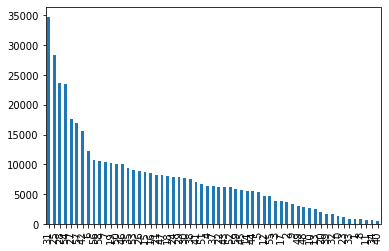

In [36]:
clean_basket_df['shop_id'].value_counts().plot(kind='bar')

<AxesSubplot:xlabel='item_price', ylabel='item_cnt_day'>

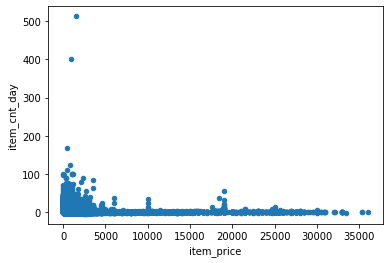

In [37]:
clean_basket_df.plot(x='item_price', y='item_cnt_day', kind='scatter')

## Spazio cazzeggio

In [38]:
df = pd.DataFrame([[4,9],[4,3],[4,9],[4,3],[4, np.nan],[3,1],[3,np.nan],[2,np.nan],[np.nan,2], [np.nan,3]], columns=['A', 'B'])

In [39]:
df

,A,B
0,4.0,9.0
1,4.0,3.0
2,4.0,9.0
3,4.0,3.0
4,4.0,NaN
5,3.0,1.0
6,3.0,NaN
7,2.0,NaN
8,NaN,2.0
9,NaN,3.0


In [40]:
df['B'] = df.groupby('A')['B'].apply(lambda x: x.fillna(x.mode().iloc[0]) if len(x.mode()) == 1 else x)

In [41]:
df

,A,B
0,4.0,9.0
1,4.0,3.0
2,4.0,9.0
3,4.0,3.0
4,4.0,NaN
5,3.0,1.0
6,3.0,1.0
7,2.0,NaN
8,NaN,NaN
9,NaN,NaN


In [42]:
df['B'] = df.groupby('A')['B'].apply(lambda x: x.replace(0 if len(x.mode()) > 1 else x))

In [43]:
# df.loc[df.groupby('A')['B'].agg(lambda x: len(x.mode())) > 1, 'B'] = 0


### TDL

basket id has trailing '.0'